# Jet Tagging with Graph Neural Networks (GNN)

This notebook shows how to use a GNN for jet classification between QCD and TT jets using particle-level features represented as a graph. Note that you get some GPU time on Kaggle for free (30 hrs/week). This will make training the model here faster, but note that it won't help you with the graph building, which also does take time here. Sadly you can't turn it on just to run the training, the notebook session must be run as either CPU or GPU. If you want to experiment with GNNs and the graph building becomes annoying, just save the graphs, and then load them as you need. 

## What is a GNN?
A Graph Neural Network (GNN) is a type of neural network designed to process graph-structured data. It can learn from both node features and the graph structure. It can be used to predict information about nodes, links between nodes or graphs as a whole. 

## Why use GNNs for Jet Tagging?
- Very flexible, can start from images or dataframes, or use both 
- Has the potential to remove areas where there is no energy deposited
- Has the potential to include long range interactions in a way a CNN can't 
- Can handle variable number of particles

## 1. Load and Prepare Data

We will create the graphs from images, but there are many other ways to do it. 

The energy deposited in a pixel will be the node feature, and we will connect each pixel to its eight closest pixels (up, down, sides, diagonals). 

The graph building function written here has an option to set max_nodes, which will only choose the top n most energetic nodes. There's also an option whether to consider all nodes or not, if you set this to false, it will throw away all the pixels with 0 energy deposited. 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv
from torch_geometric.data import Data, DataLoader
import sys
sys.path.append('..')
from utils.data_processing import load_images
from utils.data_processing import create_graph_data
from utils.data_processing import load_processed_data 
from utils.plotting import plot_confusion_matrix, plot_training_history, plot_roc_curve
from utils.data_processing import anti_kt_clustering, extract_cluster_features
from utils.data_loading import process_jet_to_clusters
from torch_geometric.utils import dense_to_sparse

In [2]:
# Load data
X_train, y_train, train_ids, X_val, y_val, val_ids, X_test, test_ids = load_images()

In [12]:
# # Convert to graph format - this might take a bit of time to run 
# X_train_graphs_images = create_graph_data(X_train, y_train, max_nodes=900, consider_all_nodes=True)
# X_val_graphs_images = create_graph_data(X_val, y_val, max_nodes=900)
# X_test_graphs_images = create_graph_data(X_test, max_nodes=900)

Created 3520 graphs
Average number of nodes: 900.0
Average number of edges: 7332.0
Created 502 graphs
Average number of nodes: 900.0
Average number of edges: 7332.0
Created 1005 graphs
Average number of nodes: 900.0
Average number of edges: 7332.0


In [3]:
def compute_eccentricity(pt, eta, phi):
    # Compute weighted mean
    eta_mean = (pt * eta).sum() / pt.sum()
    phi_mean = (pt * phi).sum() / pt.sum()
    
    # Center coordinates
    eta_centered = eta - eta_mean
    phi_centered = phi - phi_mean
    
    # Weighted covariance matrix components
    w = pt
    cov_00 = (w * eta_centered * eta_centered).sum() / w.sum()
    cov_01 = (w * eta_centered * phi_centered).sum() / w.sum()
    cov_11 = (w * phi_centered * phi_centered).sum() / w.sum()
    
    cov = torch.tensor([[cov_00, cov_01],
                        [cov_01, cov_11]])
    
    eigvals = torch.linalg.eigvalsh(cov)
    eccentricity = torch.sqrt(1 - eigvals.min() / eigvals.max()).item()
    return eccentricity

def create_cluster_data(jet_images, labels=None, max_nodes=12, test_ids = None):
    data_list=[]
    nodeless=[]
    if labels is None:
        labels = np.zeros(len(jet_images))
    for i, (image, label) in enumerate(zip(jet_images, labels)):
        clusters=anti_kt_clustering(image, R=0.4, pt_min=0.05)
        for j, c in enumerate(clusters):
            cl=c[0].tolist()
            clusters[j]=cl
        clusters=np.array(clusters)
        clusters=clusters[clusters[:, 2].argsort()]
        n_nodes=len(clusters)
        if n_nodes < 2:
            if test_ids is not None:
                nodeless.append(test_ids[i])
            else:
                nodeless.append(i)
        if n_nodes > max_nodes:
            clusters=clusters[n_nodes-max_nodes:]
            n_nodes=len(clusters)
        node_features=clusters
        adj_matrix = np.zeros((n_nodes, n_nodes))
        edge_features = np.zeros((n_nodes, n_nodes))
        for k in range(n_nodes):
            indices = np.arange(n_nodes)
            indices = np.delete(indices, k)
            adj_matrix[k, indices] = 1
            adj_matrix[indices, k] = 1  # Make it symmetric
        
        x = torch.FloatTensor(clusters).view(-1, 3)
        adj = torch.ones((n_nodes, n_nodes)) - torch.eye(n_nodes)
        edge_index = dense_to_sparse(adj)[0]  # shape [2, num_edges]

        # Compute edge features as difference between node features
        row, col = edge_index
        edge_attr = x[row] - x[col]  # shape: [num_edges, 3]

        # --- Global features ---
        pt = x[:, 2]
        eta = x[:, 0]
        phi = x[:, 1]
        
        global_features = torch.tensor([
            float(x.shape[0]),               # num_nodes
            # float(pt.var(unbiased=False)),   # var pt
            # float(eta.var(unbiased=False)),  # var eta
            # float(pt.sum()),                 # total pt
            # float(compute_eccentricity(pt, eta, phi))
            float(pt.max()),
            float(eta.abs().max())
        ], dtype=torch.float)

        y_tensor = torch.tensor(label, dtype=torch.float)
        # data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y_tensor, global_features=global_features)
        if n_nodes < 3:
            x = torch.zeros((1, 3), dtype=torch.float)           # 3 = num_node_features
            edge_index = torch.empty((2, 0), dtype=torch.long)
            edge_attr = torch.empty((0, 3), dtype=torch.float)   # 3 = edge feature dim
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, 
                        global_features=global_features,
                        y=y_tensor,
                        use_gnn=False)
        else:
            data = Data(x=x,
                        edge_index=edge_index,
                        edge_attr=edge_attr,
                        global_features=global_features,
                        y=y_tensor,
                        use_gnn=True)
        data_list.append(data)
    # print(f"Created {len(data_list)} graphs")
    # print(f"Average number of nodes: {np.mean([data.num_nodes for data in data_list]):.1f}")
    # print(f"Average number of edges: {np.mean([data.num_edges for data in data_list]):.1f}")
    
    return data_list, nodeless

In [4]:
# Convert to graph format
X_train_graphs, X_train_nodeless = create_cluster_data(X_train, y_train, max_nodes=12)
X_val_graphs, X_val_nodeless = create_cluster_data(X_val, y_val, max_nodes=12)
X_test_graphs, X_test_nodeless = create_cluster_data(X_test, max_nodes=12, test_ids=test_ids)

In [13]:
def create_graph_data_glob(jet_images, labels=None, max_nodes=100, consider_all_nodes=True):
    """
    Convert jet images to graph format for GNN using PyTorch Geometric format
    Args:
        jet_images: Array of shape (N, 30, 30, 1) containing jet images
        labels: Array of labels corresponding to the images
        max_nodes: Maximum number of nodes per graph (default: 100)
    Returns:
        List of PyTorch Geometric Data objects containing node features, edge indices, and labels
    """
    data_list = []
    jet_images_mean = jet_images.mean()
    jet_images_std = jet_images.std()
    
    # # Normalize the input images
    # jet_images = (jet_images - jet_images.mean()) / (jet_images.std() + 1e-8)
    if labels is None:
        labels = np.zeros(len(jet_images))
    # Iterate over each image and its corresponding label
    for i, (image, label) in enumerate(zip(jet_images, labels)):
        clusters=anti_kt_clustering(image, R=0.4, pt_min=0.05)
        for j, c in enumerate(clusters):
            cl=c[0].tolist()
            clusters[j]=cl
        n_clusters=len(clusters)
        clusters=np.array(clusters)
        clusters=clusters[clusters[:, 2].argsort()] # sort clusters by pt
        clusters = torch.FloatTensor(clusters).view(-1, 3)
        # --- Global features from clusters ---
        cluster_pts = clusters[:, 2]
        cluster_etas = clusters[:, 0]
        cluster_phis = clusters[:, 1]
        # pt_max = float(cluster_pts.max())
        # eta_max = float(cluster_etas.abs().max())
        # phi_max = float(cluster_phis.abs().max())
        # var_pt = float(cluster_pts.var(unbiased=False)),   # var pt
        # var_eta = float(cluster_etas.var(unbiased=False)),  # var eta
        # total_pt = float(cluster_pts.sum()),                 # total pt
        eccentricity = float(compute_eccentricity(cluster_pts, cluster_etas, cluster_phis))
        pt_ratio = float(cluster_pts[0] / cluster_pts[1]) if n_clusters > 1 else 1.0

        if n_clusters > 1:
            global_features = torch.tensor([
                n_clusters,                                               # num_nodes
                float(cluster_pts.var(unbiased=False)),                   # var pt
                float(cluster_etas.var(unbiased=False)),                  # var eta
                float(cluster_pts.sum()),                                 # total pt
                eccentricity,                                             # eccentricity
                float(cluster_pts.max()),                                 # max pt
                float(cluster_etas.abs().max()),                          # max eta
                float(cluster_phis.abs().max()),                          # phi max
            ], dtype=torch.float)
        elif n_clusters == 1:
            global_features = torch.tensor([
                n_clusters,                                               # num_nodes
                0.,                                                       # var pt
                0.,                                                       # var eta
                float(cluster_pts.sum()),                                 # total pt
                0.,                                                        # eccentricity
                float(cluster_pts.max()),                                 # max pt
                float(cluster_etas.abs().max()),                          # max eta
                float(cluster_phis.abs().max()),                          # phi max
            ], dtype=torch.float)
        else:
            global_features = torch.tensor([
                0.,                                                       # num_nodes
                0.,                                                       # var pt
                0.,                                                       # var eta
                0.,                                                       # total pt
                0.,                                                       # eccentricity
                0.,                                                       # max pt
                0.,                                                       # max eta
                0.,                                                       # phi max
            ], dtype=torch.float)

        # Normalize the input image
        image = (image - jet_images_mean) / (jet_images_std + 1e-8)
        # Get image dimensions (30x30x1)
        height, width = image.shape[:2]
        
        # Create node features and their 2D coordinates
        node_features = []
        node_coords = []
        
        # Get non-zero pixels and their coordinates
        for row in range(height):
            for col in range(width):
                intensity = image[row, col, 0]
                if intensity > 0 or consider_all_nodes:  # Only consider non-zero pixels
                    node_features.append(intensity)
                    node_coords.append((row, col))
        
        node_features = np.array(node_features)
        node_coords = np.array(node_coords)
        
        # Select top nodes by intensity if needed
        if len(node_features) > max_nodes:
            # Get indices of top max_nodes pixels by intensity
            top_indices = np.argsort(node_features)[-max_nodes:]
            node_features = node_features[top_indices]
            node_coords = node_coords[top_indices]
        
        n_nodes = len(node_features)
        
        # Create adjacency matrix based on spatial proximity
        adj_matrix = np.zeros((n_nodes, n_nodes))
        
        # For each node, connect to its k nearest neighbors
        for h in range(n_nodes):
            # Calculate distances to all other nodes
            distances = np.sqrt(np.sum((node_coords - node_coords[h])**2, axis=1))
            # Connect to k nearest neighbors (excluding self)
            k = min(8, n_nodes - 1)  # Connect to up to 8 nearest neighbors
            nearest_indices = np.argsort(distances)[1:k+1]  # Skip first (self)
            adj_matrix[h, nearest_indices] = 1
            adj_matrix[nearest_indices, h] = 1  # Make it symmetric
        
        # Convert to PyTorch tensors and create edge_index
        x = torch.FloatTensor(node_features).view(-1, 1)  # Shape: (n_nodes, 1)
        edge_index = torch.nonzero(torch.FloatTensor(adj_matrix)).t()  # Shape: (2, num_edges)
        y = torch.tensor(label, dtype=torch.float)
        
        # Validate graph structure
        if edge_index.shape[1] == 0:
            print(f"Warning: Graph {i} has no edges")
            continue
        
        if x.shape[0] == 0:
            print(f"Warning: Graph {i} has no nodes")
            continue
        
        # Create PyTorch Geometric Data object
        data = Data(x=x, edge_index=edge_index, y=y, global_features=global_features)
        data_list.append(data)

        if i % 100 == 0:
            print(f"Finished {i} of {len(jet_images)}")
    
    print(f"Created {len(data_list)} graphs")
    print(f"Average number of nodes: {np.mean([data.num_nodes for data in data_list]):.1f}")
    print(f"Average number of edges: {np.mean([data.num_edges for data in data_list]):.1f}")
    
    return data_list

In [14]:
# Convert to graph format - this might take a bit of time to run 
X_train_graphs_images = create_graph_data_glob(X_train, y_train, max_nodes=900, consider_all_nodes=True)
X_val_graphs_images = create_graph_data_glob(X_val, y_val, max_nodes=900)
X_test_graphs_images = create_graph_data_glob(X_test, max_nodes=900)

Finished 0 of 3520
Finished 100 of 3520
Finished 200 of 3520
Finished 300 of 3520
Finished 400 of 3520
Finished 500 of 3520
Finished 600 of 3520
Finished 700 of 3520
Finished 800 of 3520
Finished 900 of 3520
Finished 1000 of 3520
Finished 1100 of 3520
Finished 1200 of 3520
Finished 1300 of 3520
Finished 1400 of 3520
Finished 1500 of 3520
Finished 1600 of 3520
Finished 1700 of 3520
Finished 1800 of 3520
Finished 1900 of 3520
Finished 2000 of 3520
Finished 2100 of 3520
Finished 2200 of 3520
Finished 2300 of 3520
Finished 2400 of 3520
Finished 2500 of 3520
Finished 2600 of 3520
Finished 2700 of 3520
Finished 2800 of 3520
Finished 2900 of 3520
Finished 3000 of 3520
Finished 3100 of 3520
Finished 3200 of 3520
Finished 3300 of 3520
Finished 3400 of 3520
Finished 3500 of 3520
Created 3520 graphs
Average number of nodes: 900.0
Average number of edges: 7332.0
Finished 0 of 502
Finished 100 of 502
Finished 200 of 502
Finished 300 of 502
Finished 400 of 502
Finished 500 of 502
Created 502 graphs


## 2. Build GNN Model

We'll create a GNN with:
- Graph Convolutional layers to learn from node features and graph structure
- Global pooling to get graph-level representations
- Dense layers for classification

In [38]:
from torch_geometric.nn import NNConv
from torch_geometric.nn import TransformerConv

class GNN(nn.Module):
    def __init__(self, num_node_features, global_feat_dim=3):
        super(GNN, self).__init__()
        # self.conv1 = TransformerConv(in_channels=num_node_features, out_channels=64, edge_dim=edge_feat_dim, heads=2)
        # self.conv2 = TransformerConv(in_channels=64 * 2, out_channels=32, edge_dim=edge_feat_dim, heads=2)
        # self.conv3 = TransformerConv(in_channels=32 * 2, out_channels=16, edge_dim=edge_feat_dim, heads=1)

        self.global_mlp = nn.Sequential(
            nn.Linear(global_feat_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 8)
        )

        # self.global_only_mlp = nn.Sequential(
        #     nn.Linear(global_feat_dim, 16),
        #     nn.ReLU(),
        #     nn.Linear(16, 1)  # output dim = num_classes
        # )

        # self.fc1 = nn.Linear(16 + 8, 8)
        # # self.fc1 = nn.Linear(16, 8)
        # self.fc2 = nn.Linear(8, 1)

        # Graph attention layers
        self.conv1 = GATConv(num_node_features, 32, heads=2, concat=True)
        self.conv2 = GATConv(64, 16, heads=2, concat=True)
        self.conv3 = GATConv(32, 16, heads=1, concat=True)
        
        # Dense layers
        self.fc1 = nn.Linear(16 + 8, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, data):
        # if not data.use_gnn.any():
        #     x=self.global_only_mlp(data.global_features)
        #     return torch.sigmoid(x)
        
        x, edge_index, batch = data.x, data.edge_index, data.batch
        global_feat = data.global_features 

        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv3(x, edge_index))

        x = global_mean_pool(x, batch)  # [num_graphs, 16]
        g = self.global_mlp(global_feat.view(-1, 8))  # [num_graphs, 8]

        x = torch.cat([x, g], dim=1)  # [num_graphs, 24]
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)

        return torch.sigmoid(x)

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

model = GNN(num_node_features=1, global_feat_dim=8).to(device)  # 4 features: pt, eta, phi, charge
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [39]:
# train_loader = DataLoader(X_train_graphs, batch_size=30, shuffle=True)
# val_loader = DataLoader(X_val_graphs, batch_size=30, shuffle=True)
# test_loader = DataLoader(X_test_graphs, batch_size=30)

train_loader = DataLoader(X_train_graphs_images, batch_size=30, shuffle=True)
val_loader = DataLoader(X_val_graphs_images, batch_size=30, shuffle=True)
test_loader = DataLoader(X_test_graphs_images, batch_size=30)

## 3. Train Model

We'll train the GNN with:
- Adam optimizer
- Binary Cross Entropy loss
- Early stopping based on validation accuracy


You'll see this code differs a fair bit from the previous DNN and CNN. This is because we're using pytorch geometric -  the most common GNN package. It integrates with Pytorch, so we are using Pytorch instead of keras. Torch is growing to be the most popular ML libary, but keras is easier to learn. 

You might also see that training on CPU this is a lot slower than the other ML methods. Can you explain why? 

In [40]:
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.to(device))
        loss = criterion(out, data.y.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.to(device))
        loss = criterion(out, data.y.view(-1, 1))
        pred = (out > 0.5).float()
        correct += int((pred == data.y.view(-1, 1)).sum())
    return correct / len(loader.dataset), loss


history = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}


# Training loop
best_acc = 0
for epoch in range(60):
    loss = train()
    train_acc = test(train_loader)[0]
    val_acc, val_loss = test(val_loader)
    val_loss=val_loss.cpu()
    val_loss=val_loss.detach().numpy()
    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pt')


    # Append to history
    history['loss'].append(loss)
    history['val_loss'].append(val_loss)
    history['accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)

Epoch 000, Loss: 0.5881, Train Acc: 0.6557, Val Acc: 0.6633
Epoch 001, Loss: 0.5095, Train Acc: 0.8108, Val Acc: 0.8327
Epoch 002, Loss: 0.4620, Train Acc: 0.7435, Val Acc: 0.7590
Epoch 003, Loss: 0.4377, Train Acc: 0.8389, Val Acc: 0.8526
Epoch 004, Loss: 0.4327, Train Acc: 0.8290, Val Acc: 0.8446
Epoch 005, Loss: 0.4405, Train Acc: 0.8196, Val Acc: 0.8446
Epoch 006, Loss: 0.4496, Train Acc: 0.8310, Val Acc: 0.8426
Epoch 007, Loss: 0.4451, Train Acc: 0.8332, Val Acc: 0.8466
Epoch 008, Loss: 0.4459, Train Acc: 0.8327, Val Acc: 0.8486
Epoch 009, Loss: 0.4290, Train Acc: 0.8557, Val Acc: 0.8665
Epoch 010, Loss: 0.4209, Train Acc: 0.8352, Val Acc: 0.8546
Epoch 011, Loss: 0.4278, Train Acc: 0.8426, Val Acc: 0.8566
Epoch 012, Loss: 0.4361, Train Acc: 0.8156, Val Acc: 0.8167
Epoch 013, Loss: 0.4147, Train Acc: 0.8562, Val Acc: 0.8685
Epoch 014, Loss: 0.4245, Train Acc: 0.8037, Val Acc: 0.7988
Epoch 015, Loss: 0.4278, Train Acc: 0.7901, Val Acc: 0.7849
Epoch 016, Loss: 0.4360, Train Acc: 0.77

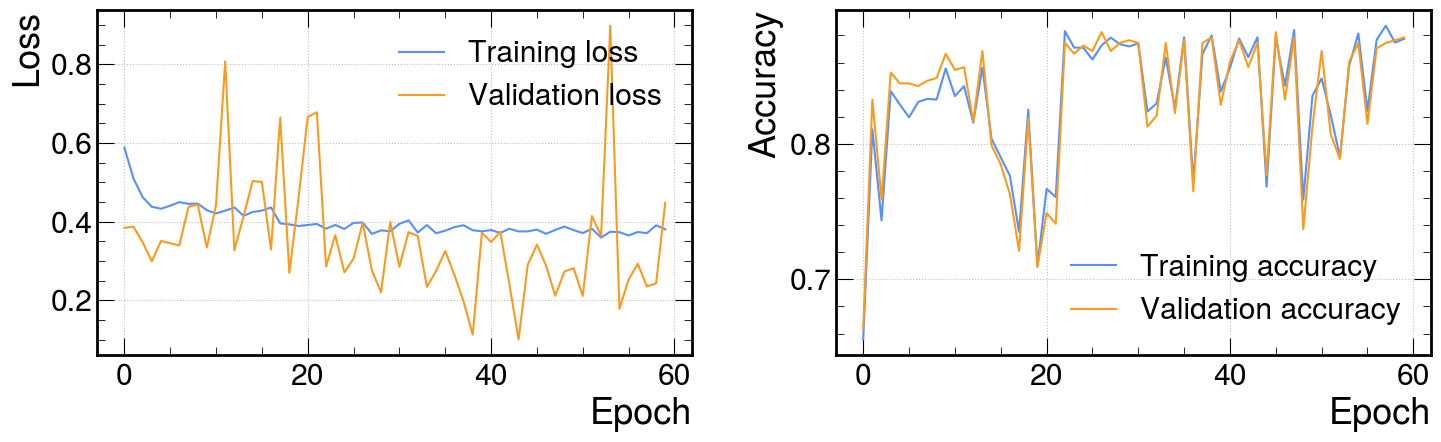

In [41]:
plot_training_history(history, metrics=['loss', 'accuracy'])

## 4. Evaluate Model

Let's evaluate our model's performance on the test set.

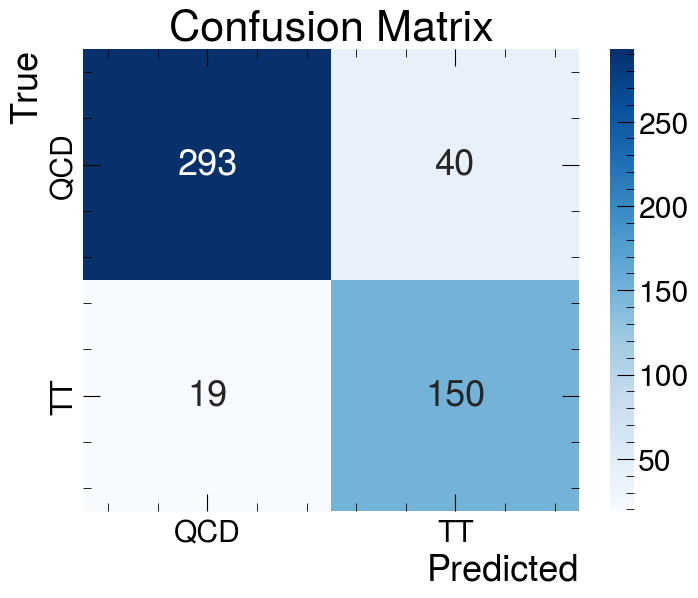

In [42]:
# Load best model
model.load_state_dict(torch.load('best_model.pt'))

# Evaluate on test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad(): 
    for data in val_loader:
        out = model(data.to(device))
        y_true.extend(data.to('cpu').y.numpy())
        y_pred.extend(out.to('cpu').numpy())

y_pred = np.array([x[0] for x in y_pred])
pred_discrete = np.where(y_pred > 0.5, 1, 0)
# Plot confusion matrix
plot_confusion_matrix(y_true, pred_discrete)

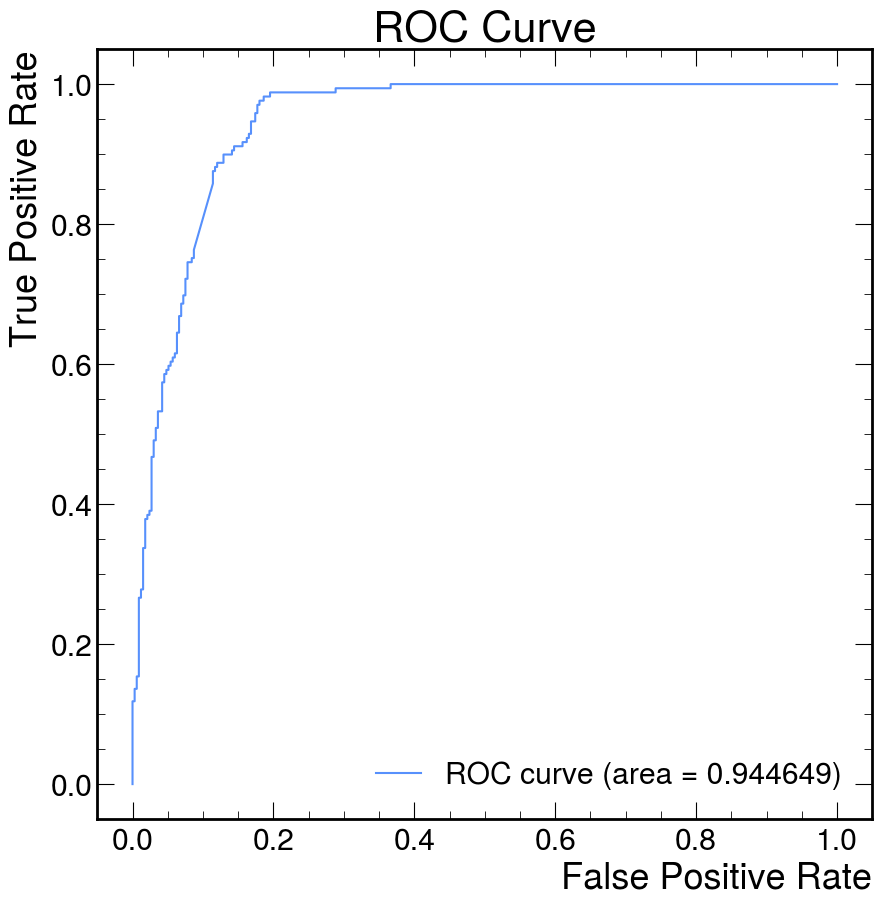

In [43]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.6f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(y_true, y_pred)

# 5 - Making predictions

In [14]:
y_pred_test = []
for data in test_loader:
    with torch.no_grad():
        output = model(data.to(device))
        # could you change the prediction threshold? Would that make it better?
        y_pred_test.extend(output.to('cpu').numpy())

y_pred_test = np.array([x[0] for x in y_pred_test])


In [15]:
import pandas as pd
solution = pd.DataFrame({'id':test_ids, 'label':y_pred_test})
solution.to_csv('solution.csv', index=False)